## Instalando as bibliotecas

In [ ]:
from qrcode_reader import show_qrcode_detected
% pip install numpy matplotlib scikit-image cv2

## Importando bibliotecas

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, filters, feature
import cv2
import os

### Carregando a imagem

In [114]:
DATASET_DIRECTORY = 'dataset'
IMAGE_NAME = '74943320.png'

image_path = os.path.join(DATASET_DIRECTORY, IMAGE_NAME)

image = io.imread(image_path)

if image.shape[-1] == 4:
    image = image[:,:,:3] # Removendo o canal alpha

image_gray = color.rgb2gray(image)
image_numpy = np.array(image_gray)


### Localizando o local do QR Code na imagem

#### Funções auxiliares

In [4]:
def encontrar_bbox(img_numpy, tollerance=5):

    linhas, colunas = np.where(img_numpy == 0)  # Pega as coordenadas dos pixels pretos

    if len(linhas) == 0 or len(colunas) == 0:
        return None

    # Determina os extremos da bounding box
    y_min, y_max = linhas.min(), linhas.max()
    x_min, x_max = colunas.min(), colunas.max()

    # Adicionando tolerância
    y_min, y_max = y_min - tollerance, y_max + tollerance
    x_min, x_max = x_min - tollerance, x_max + tollerance

    return x_min, y_min, x_max, y_max

def show_qrcode_detected(bbox, img):
    x_min, y_min, x_max, y_max = bbox
    return img[y_min:y_max, x_min:x_max]

def binarize_image(img, limiar=128):
    return (image > limiar).astype(int)  # Converte para 1 (branco) e 0 (preto)

#### Recortando o qr code na imagem

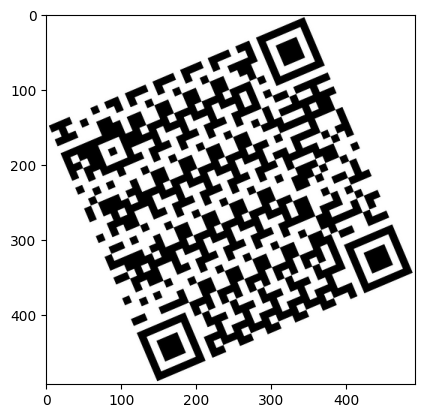

In [115]:
bbox = encontrar_bbox(image_numpy)

bbox_image = show_qrcode_detected(bbox, image_numpy)

plt.imshow(bbox_image, cmap='gray')
plt.show()
plt.imsave('qrcode_detected.png', bbox_image, cmap='gray')

### Ajuste do ângulo da imagem

In [116]:
# Detecta as bordas com o Canny
# edges = filters.sobel(bbox_image) # Tentamos usar sobel, mas não foi eficaz
edges = feature.canny(bbox_image, sigma=2.0)

# Define um range de ângulos para testar (-45° a 45°)
tested_angles = np.linspace(-np.pi/4, np.pi/4, 100)

# Aplica a transformada de Hough para detectar linhas
h, theta, d = transform.hough_line(edges, theta=tested_angles)

# Seleciona os picos das linhas detectadas
accums, angles, dists = transform.hough_line_peaks(h, theta, d)

if len(angles) == 0:
    print("Nenhuma linha detectada. A rotação não pôde ser estimada.")
    rotation_angle = 0
else:
    # Estima o ângulo de rotação usando a mediana dos ângulos detectados
    rotation_angle = np.median(angles)

# Converte o ângulo para graus (para visualização e correção)
angle_deg = np.degrees(rotation_angle)
print("Ângulo detectado (em graus):", angle_deg)


# Corrige a rotação
corrected_image = transform.rotate(bbox_image, angle_deg, resize=False, cval=1.0)

Ângulo detectado (em graus): -23.18181818181818
(493, 492)


### Recortando a imagem com a inclinação corrigida

In [118]:
img_final = show_qrcode_detected(encontrar_bbox(corrected_image), corrected_image)

### Exibindo os resultados

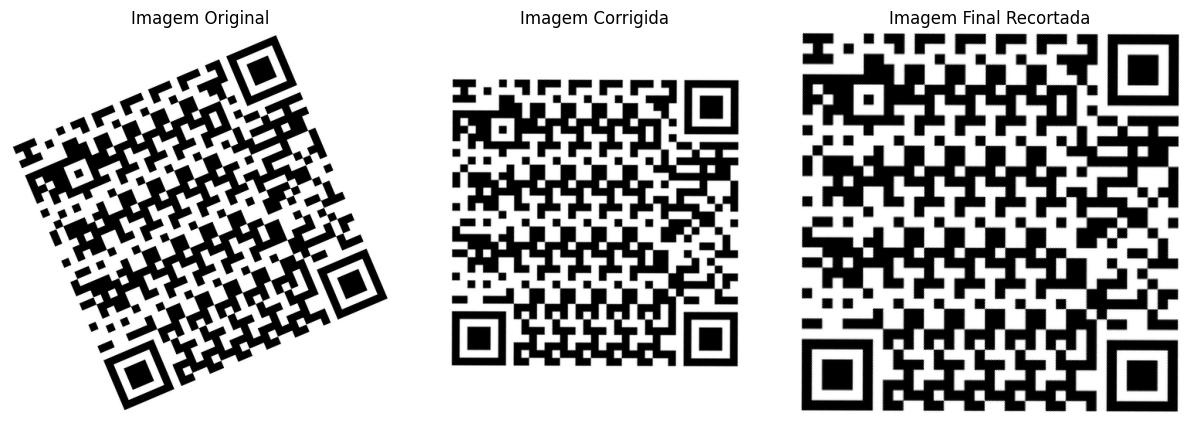

True

In [121]:
# Exibe a imagem original, a imagem com a correção de rotação e a imagem final recortada
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(bbox_image, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(corrected_image, cmap='gray')
axes[1].set_title('Imagem Corrigida')
axes[1].axis('off')

axes[2].imshow(img_final, cmap='gray')
axes[2].set_title('Imagem Final Recortada')
axes[2].axis('off')

plt.tight_layout()
plt.show()
corrected_image_uint8 = (img_final * 255).astype(np.uint8)


cv2.imwrite('qrcode_detected_rotated.png',corrected_image_uint8)

